In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.decomposition import PCA

In [3]:
data_path = r"SMSSpamCollection"
df = pd.read_csv(data_path, sep='\t', names=["label", "message"])

print(df.head())
print("\nClass Distribution:\n", df["label"].value_counts())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Class Distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
#Preprocessing & Feature Extraction
X = df["message"]
y = df["label"]

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X_vec = vectorizer.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
#Train SVM Models
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train, y_train)

# RBF Kernel
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train, y_train)

SVC(C=1)


=== SVM Linear Performance ===
Accuracy: 0.9811659192825112
F1-Score: 0.9247311827956989
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



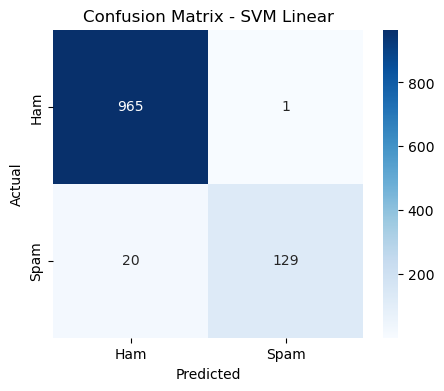


=== SVM RBF Performance ===
Accuracy: 0.9721973094170404
F1-Score: 0.8838951310861424
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



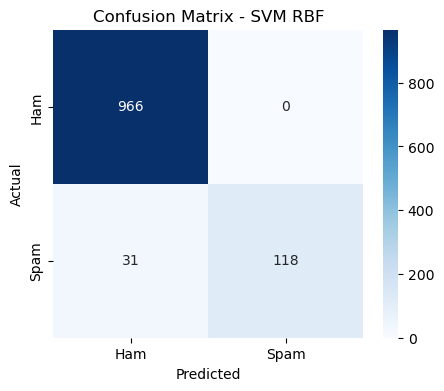

In [9]:
 # Evaluation
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label='spam')

    print(f"\n=== {name} Performance ===")
    print("Accuracy:", acc)
    print("F1-Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

evaluate_model(svm_linear, X_test, y_test, "SVM Linear")
evaluate_model(svm_rbf, X_test, y_test, "SVM RBF")

In [11]:
# Hyperparameter Tuning

param_grid = {
'C': [0.1, 1, 10],
'gamma': ['scale', 0.1, 0.01],
'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)


print("\nBest Parameters:", grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


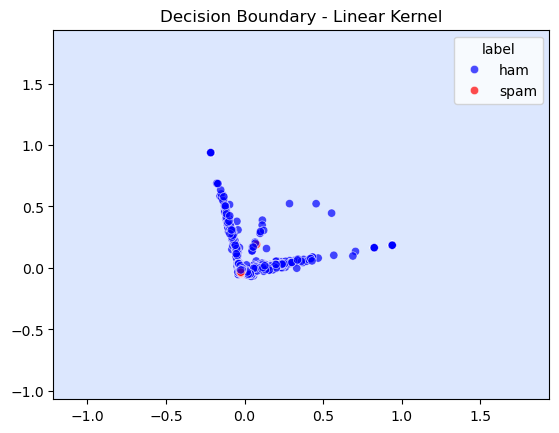

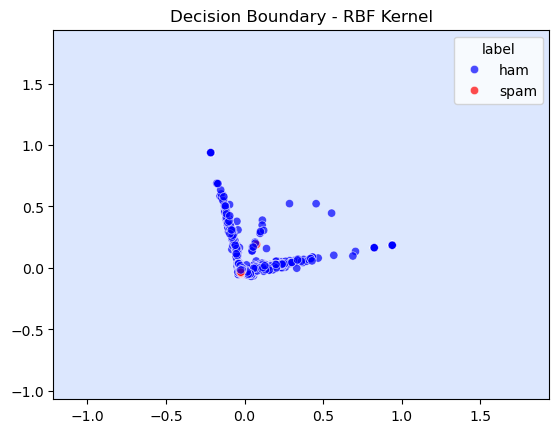

In [12]:
#visualization 
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train.toarray())

# Retrain models on reduced space
svm2d_linear = SVC(kernel='linear', C=1).fit(X_train_2d, y_train)
svm2d_rbf = SVC(kernel='rbf', C=1, gamma='scale').fit(X_train_2d, y_train)

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array([0 if val=='ham' else 1 for val in Z])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette={"ham":"blue", "spam":"red"}, alpha=0.7)
    plt.title(title)
    plt.show()

plot_decision_boundary(svm2d_linear, X_train_2d, y_train, "Decision Boundary - Linear Kernel")
plot_decision_boundary(svm2d_rbf, X_train_2d, y_train, "Decision Boundary - RBF Kernel")

### Key Questions / Analysis / Interpretation  

**Q1. Can SVM effectively separate spam and non-spam emails based on textual features?**  
SVM can separate spam and non-spam emails well.  
Email text is converted into numbers (like TF-IDF), and SVM finds the best dividing line (hyperplane).  
It works well even with many features and gives high accuracy.  

**Q2. How does changing the kernel (linear, polynomial, RBF) affect performance?**  
Linear kernel works if data is mostly straight-line separable, simple and fast.  
Polynomial kernel can handle more complex patterns but may overfit small data.  
RBF kernel handles non-linear data well and usually performs best on complex text.  

**Q3. What is the optimal decision boundary, and how is it determined?**  
The optimal boundary is the line or hyperplane that keeps the biggest distance (margin) from both classes.  
SVM calculates it to balance correct classification and maximum margin.  

**Q4. How does margin maximization improve generalization?**  
A larger margin makes the model less sensitive to noise or small changes in data.  
This helps it work better on new, unseen emails.  

**Q5. What insights can be gained by visualizing high-dimensional data?**  
PCA or t-SNE can reduce data dimensions for plotting.  
This shows clusters, overlaps, and separability of classes.  
It helps decide which kernel or preprocessing to use.


### Supplementary Problem (PRAC-8)

**Document classification.** 


In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [19]:
data = {
    'email_text': [
        'Win money now', 'Meeting at 10 am', 'Cheap meds available', 'Project report attached',
        'Congratulations you won', 'Lunch tomorrow?', 'Earn cash fast', 'Schedule for next week',
        'Discount offer just for you', 'Team meeting agenda'
    ],
    'label': ['spam','ham','spam','ham','spam','ham','spam','ham','spam','ham']
}

In [21]:
df = pd.DataFrame(data)

In [23]:
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

In [25]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['email_text'])
y = df['label_enc']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [29]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear Kernel Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))


Linear Kernel Accuracy: 0.3333333333333333
Confusion Matrix:
 [[0 2]
 [0 1]]


In [31]:
svm_poly = SVC(kernel='poly', degree=2)
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("Polynomial Kernel Accuracy:", accuracy_score(y_test, y_pred_poly))


Polynomial Kernel Accuracy: 0.3333333333333333


In [37]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("RBF Kernel Accuracy:", accuracy_score(y_test, y_pred_rbf))

RBF Kernel Accuracy: 0.3333333333333333
